In [21]:
import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.transforms import functional as transformF
import torchvision.utils as vutils
from torchvision.io import read_image,ImageReadMode
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from PIL import Image
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt 
import gc
from IPython.display import clear_output

In [22]:
from patchdisc import PatchDiscriminator
from UNet import Unet
from FlowGenV2 import FlowGen
from datasets import DNSDatasetCustom, full_dns_dataset
from Loss import *

Cambiare il path con quello della directory su cui verrà effettuato il training.

In [23]:
PATH="C:\\Users\\vicin\Desktop\\PoliTo\\ML_for_CV\\CGAN"
BATCH_SIZE=16

In [24]:
class DNSDataset(Dataset):
    def __init__(self, img_dir, seg=True, norm=True, depth=True, with_previous=False, transforms=None, target_transforms=None):
        self.img_dir=img_dir
        self.imgs_depth=[]
        self.imgs_norm=[]
        self.imgs_seg=[]
        self.imgs_col=[]
        self.norm=norm
        self.seg=seg
        self.depth=depth
        self.with_previous=with_previous

        if depth:
            self.imgs_depth.extend([self.img_dir + '\\Depth\\'+i for i in os.listdir(self.img_dir+'\\Depth') if i.endswith('.png')])
        if norm:
            self.imgs_norm.extend([self.img_dir + '\\Normal\\'+i for i in os.listdir(self.img_dir+'\\Normal') if i.endswith('.png')])
        if seg:
            self.imgs_seg.extend([self.img_dir + '\\Segmentation\\'+i for i in os.listdir(self.img_dir+'\\Segmentation') if i.endswith('.png')])
        
        self.imgs_col.extend([self.img_dir + '\\Default\\'+i for i in os.listdir(self.img_dir+'\\Default') if i.endswith('.png')])
        
        self.transforms=transforms
        self.target_transforms=target_transforms
    def __getitem__(self, index) -> torch.Tensor:
        tensors=[]
        if self.with_previous:
            prev_frame=transformF.to_tensor(Image.open(self.imgs_col[0]))[0:3] #index invece che 0
            tensors.append(prev_frame)
            index=index+1

        if self.depth:
            depth=transformF.to_tensor(transformF.to_grayscale(Image.open(self.imgs_depth[index])))
            tensors.append(depth)
        if self.norm:
            norm=transformF.to_tensor(Image.open(self.imgs_norm[index]))[0:3]
            tensors.append(norm)
        if self.seg:
            seg=transformF.to_tensor(Image.open(self.imgs_seg[index]))[0:3]
            tensors.append(seg)
        col=transformF.to_tensor(Image.open(self.imgs_col[index]))[0:3]
        
        
        
        return torch.cat(tensors,0), col
        
    def __len__(self):
        if self.with_previous:
            return len(self.imgs_col)-1
        return len(self.imgs_col)

In [25]:
#Test Dataset

input_transform = transforms.Compose([
        transforms.Normalize(mean=[0,0,0], std=[255,255,255]),
        transforms.Normalize(mean=[0.45,0.432,0.411], std=[1,1,1])
    ])

co_transform = transforms.Compose([
            
            transforms.RandomRotation(10,interpolation=transforms.InterpolationMode.BILINEAR,expand=True),
            transforms.RandomCrop((256,256)),
            transforms.RandomVerticalFlip(),
            transforms.RandomHorizontalFlip()
        ])

dataset_train=DNSDatasetCustom(PATH+'\\dataset\\Cam 1', set_order='dc,ds')
dataset_train_2=DNSDatasetCustom(PATH+'\\dataset\\Cam 2',  set_order='dc,ds')
dataset_train_3=DNSDatasetCustom(PATH+'\\dataset\\Cam 3', set_order='dc,ds')
dataset_train_4=DNSDatasetCustom(PATH+'\\dataset\\Cam 4', set_order='dc,ds')
dataset_test=DNSDataset(PATH+'\\dataset\\Cam 4', norm=False, with_previous=True)

dataset_train=ConcatDataset((dataset_train,dataset_train_2, dataset_train_3))

dataset_train=full_dns_dataset(PATH+'\\dataset', 'Cam ',1,10, 'dc,dsn',transforms=input_transform, co_transform=co_transform)
#dataset_train,_=random_split(dataset_train,[32,len(dataset_train)-32])
dataloader_train=DataLoader(dataset_train,BATCH_SIZE, shuffle=True)
dataloader_test=DataLoader(dataset_train_4,BATCH_SIZE, shuffle=True)



# plt.subplot(121)
# plt.imshow(img0_norm.permute(1,2,0))
# plt.subplot(122)
# plt.imshow(img0_depth.permute(1,2,0))

In [26]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [27]:
### TEST ###
r=torch.randn(16,100,2,2).cuda()

print(r.shape)

flowgen=FlowGen(unet_pretrained='.\\models\\neverStreetsUnet.pth.tar').cuda()
flowgen.reload_pretrained()
flowgen.apply(weights_init)

patch_discriminator=PatchDiscriminator(18,32).cuda()
patch_discriminator.apply(weights_init)

with torch.no_grad():
    r=torch.randn(1,18,256,256).cuda()
    patch_shape=list(patch_discriminator(r).shape[1:4])
    print(patch_shape)


torch.Size([16, 100, 2, 2])
dict_keys(['state_dict', 'best_EPE', 'epoch', 'arch'])
dict_keys(['Discriminator', 'optimizerDiscriminator_state_dict', 'Generator', 'optimizerUNet_state_dict', 'epoch'])
[1, 8, 8]


In [28]:
# optimizerDec=optim.Adam(decoder.parameters(), 0.0002, (0.5,0.999))

# enc_dec_param=list(decoder.parameters())+list(encoder.parameters())
# optimizerEncDec=optim.Adam(enc_dec_param, 0.0002, (0.5,0.999))

optimizerPatchDiscriminator=optim.Adam(patch_discriminator.parameters(), .0002, (0.5,0.9))
optimizerflowgen=optim.Adam(flowgen.parameters(),.0002, (0.5,0.9) )

criterion=nn.MSELoss()
criterion_flowgen=LossCustom()

# criterion=nn.BCELoss()
criterion_encoder=nn.SmoothL1Loss()

loss_iterations=0
loss_gen_values=[]
loss_gen_pix_values=[]
loss_disc_values=[]

In [29]:
### Train-Loop GAN ###
def optimize_GAN():
    global dataloader_train, loss_iterations,loss_gen_values,loss_disc_values, loss_gen_pix_values
    accuracy=0
    for (data,col) in dataloader_train:

        batch_size=len(data)
        data_gpu=data.cuda()
        col_gpu=col.cuda()

        fake_col=flowgen(data_gpu)

        ### Train Discriminator ### 
        patch_discriminator.zero_grad()
        flowgen.zero_grad()
        
        label1=torch.full([batch_size,*patch_shape], 1.).cuda() #Etichetta immagini reali

        output1=patch_discriminator(torch.cat((data_gpu,col_gpu,),1)) # predizioni
        loss_discr_real=criterion(output1, label1) # cross entropy


        accuracy+=output1.round().eq(1.).sum().item()/64

        label2=torch.full([batch_size,*patch_shape], 0.).cuda()


        output2=patch_discriminator(torch.cat((data_gpu,fake_col.detach(),), 1) )
        loss_discr_fake=criterion(output2,label2)

        accuracy+=output2.round().eq(0.).sum().item()/64

        
        loss_discr=loss_discr_real+loss_discr_fake

        loss_disc_values.append(torch.Tensor(loss_discr).item())
        loss_discr.backward()
        optimizerPatchDiscriminator.step()
        
        ### Train Generator ###
        
        output3=patch_discriminator(torch.cat((data_gpu,fake_col,),1))

        loss_gen_disc=criterion(output3, label1)
        loss_gen_pixel=criterion_flowgen(fake_col, col_gpu)
        errDec = loss_gen_disc + loss_gen_pixel

        loss_gen_pix_values.append(loss_gen_pixel.item())
        loss_gen_values.append(loss_gen_disc.item())
        
        errDec.backward()
        optimizerflowgen.step()

        loss_iterations+=1

        label1.cpu()
        label2.cpu()
        fake_col.cpu()
        data_gpu.cpu()
        col_gpu.cpu()
        gc.collect()
        torch.cuda.empty_cache()
        #data_gpu[0].split(1,2)[0].squeeze()
    return accuracy/len(dataloader_train.dataset), fake_col[0].squeeze(), col[0].squeeze()

```def optimize_encoder_decoder():
    global encoder, decoder, discriminator, dataloader_train
    accuracy=0
    for (data,seg) in dataloader_train:
        batch_size=data.shape[0]
        data_gpu=data.cuda()
        seg_gpu=seg.cuda()

        latent_batch=encoder(seg_gpu)

        fake_data=decoder(latent_batch)

        ### Train Discriminator ### 
        discriminator.zero_grad()
        decoder.zero_grad()
        encoder.zero_grad()
        

        label1=torch.full((batch_size,), 1.).cuda() #Etichetta immagini reali
        output1=discriminator(torch.cat([data_gpu,seg_gpu], dim=1)).view(-1) # predizioni
        errDisc_real=criterion(output1, label1) # cross entropy

        accuracy+=output1.eq(1.).sum().item()

        label2=torch.full((batch_size,), 0.).cuda()
        output2=discriminator(torch.cat([fake_data.detach(),seg_gpu], dim=1)).view(-1)
        errDisc_fake=criterion(output2,label2)

        accuracy+=output1.eq(0.).sum().item()

        
        errDisc=errDisc_real+errDisc_fake
        errDisc.backward()
        optimizerDisc.step()
        
        ### Train Decoder ###
        
        
        # errDec=criterion_encoder(fake_data, data_gpu)

        # errDec.backward()
        # optimizerEncDec.step()

        output3=discriminator(torch.cat([fake_data, seg_gpu], dim=1)).view(-1)
        errGen=criterion(output3, label1)
        errGen.backward()
        optimizerEncDec.step()
        fake_data.cpu()
        data_gpu.cpu()
        seg_gpu.cpu()
        gc.collect()
        torch.cuda.empty_cache()
        
    return accuracy/len(dataloader_train.dataset), fake_data[0], seg[0]```
    

Saving...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.9791771042084167


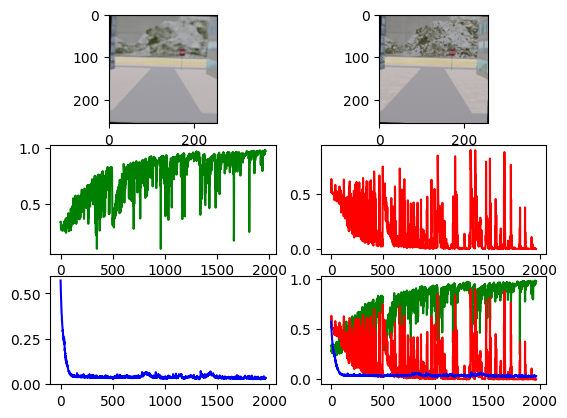

Epoch  7


KeyboardInterrupt: 

In [30]:
import json
### Train Loop ###
epochs=40
start_epoch=0
if "neverStreets.pth.tar" in os.listdir("./"):
  print("Loading...")
  try:
    state = torch.load("./neverStreets.pth.tar")
    if state:
      patch_discriminator.load_state_dict(state["Discriminator"])
      flowgen.load_state_dict(state["Generator"])
      optimizerPatchDiscriminator.load_state_dict(state["optimizerDiscriminator_state_dict"])
      optimizerflowgen.load_state_dict(state["optimizerFGen_state_dict"])
      start_epoch=state["epoch"]



  except:
    print("Error in load")

  with open('loss_data.json', 'r') as f:
    content=f.read()
    content=json.loads(content)
    loss_iterations=content['loss_iterations']
    loss_gen_values=json.loads(content['loss_gen_values'])
    loss_gen_pix_values=json.loads(content['loss_gen_pix_values'])
    loss_disc_values=json.loads(content['loss_disc_values'])

# flowgen.reload_flownet()
flowgen.reload_pretrained()


for i in range(start_epoch, epochs):
  print("Epoch ",i)
  accuracy, fake_col, col=optimize_GAN()
  
  clear_output(wait=True)
  print("Saving...")
  torch.save({"Discriminator":patch_discriminator.state_dict(),
  "optimizerDiscriminator_state_dict":optimizerPatchDiscriminator.state_dict(),
  "Generator":flowgen.state_dict(),
  "optimizerFGen_state_dict":optimizerflowgen.state_dict(),
  "epoch":i},
  "./neverStreets.pth.tar")

  content={
      'loss_iterations' : loss_iterations,
      'loss_gen_values' : json.dumps(loss_gen_values),
      'loss_gen_pix_values' : json.dumps(loss_gen_pix_values),
      'loss_disc_values' : json.dumps(loss_disc_values)
  }

  with open('loss_data.json','w') as f:
      f.write(json.dumps(content))

  print(accuracy)
  
  plt.subplot(321)
  plt.imshow(fake_col.cpu().detach().permute([1,2,0]))
  plt.subplot(322)
  plt.imshow(col.cpu().detach().permute([1,2,0]))
  plt.subplot(323)
  plt.plot(range(0,loss_iterations), loss_gen_values, 'g')
  plt.subplot(324)
  plt.plot(range(0,loss_iterations), loss_disc_values, 'r')
  plt.subplot(325)
  plt.plot(range(0,loss_iterations), loss_gen_pix_values, 'b')
  plt.subplot(326)
  plt.plot(range(0,loss_iterations), loss_gen_values, 'g')
  plt.plot(range(0,loss_iterations), loss_disc_values, 'r')
  plt.plot(range(0,loss_iterations), loss_gen_pix_values, 'b')
  plt.savefig('plot.png')
  plt.show()

In [ ]:
### Save losses ###
import json

content={
    'loss_iterations' : loss_iterations,
    'loss_gen_values' : json.dumps(loss_gen_values),
    'loss_gen_pix_values' : json.dumps(loss_gen_pix_values),
    'loss_disc_values' : json.dumps(loss_disc_values)
}

with open('loss_data.json','w') as f:
    f.write(json.dumps(content))

In [ ]:
print(loss_gen_values[-1])
print(loss_disc_values[-1])
print(loss_gen_pix_values[-1])

2.772771422188125e-11
2.769386282797104e-11
0.017692122608423233


In [ ]:
import random
generator=FlowGen().cuda()

if "neverStreets" in os.listdir("./"):
  print("Loading...")
  try:
    state = torch.load("./neverStreets")
    if state:
      generator.load_state_dict(state["Generator"])
  except:
    print("Error in load")


print(len(dataloader_test))
data,col=next(iter(dataloader_test))
#fake_data=decoder(torch.randn([16,100,1,1], device='cuda'))
r=random.randint(0, len(data)-1)
fake_col=generator(data.cuda())

to_image=transforms.ToPILImage()
plt.subplot(121)
plt.imshow(to_image(fake_col[r].clip(0,1).cpu()))
plt.subplot(122)
plt.imshow(to_image(col[r].squeeze().clip(0,1).cpu()))

32


RuntimeError: Given groups=1, weight of size [128, 7, 4, 4], expected input[16, 4, 256, 256] to have 7 channels, but got 4 channels instead